In [ ]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from unidecode import unidecode

# pd.set_option('display.max_columns', None)

## Prétraitement des données

### Premier tour

In [ ]:
t1_dep = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/bf616688-8478-46fa-8abe-cd1cc1a53b83')

t1_dep.drop(t1_dep.columns[28:52], axis=1, inplace=True)
t1_dep.drop(t1_dep.columns[[3, 5, 6, 7, 8, 10, 11, 13, 14]], axis=1, inplace=True)

t1_dep.columns = ['Code Département','Département', 'Inscrits', 'Taux Abstention', 'Taux Blanc', 'Taux Nul', 'Taux Exprimé',
                  'ARTHAUD', 'ROUSSEL', 'MACRON', 'LASSALLE', 'LE PEN', 'ZEMMOUR', 'MÉLENCHON', 'HIDALGO', 'JADOT', 'PÉCRESSE', 'POUTOU', 'DUPONT-AIGNAN']

In [ ]:
t1_dep.head()

In [ ]:
t1_parole = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/573e3191-c31d-4893-8bc2-d0429df3bf80',
                         encoding='ISO-8859-1', sep=';')

t1_parole.drop(t1_parole[t1_parole['Type de temps'] != 'Total Temps d\'antenne'].index,
               inplace=True)
t1_parole.drop(['Circonscription'], axis=1, inplace=True)
t1_parole.replace(['ARTHAUD NATHALIE','DUPONT AIGNAN NICOLAS', 'HIDALGO ANNE',
                   'JADOT YANNICK', 'LASSALLE JEAN', 'LE PEN MARINE',
                   'MACRON EMMANUEL', 'MELENCHON JEAN LUC', 'PECRESSE VALERIE',
                   'POUTOU PHILIPPE', 'ROUSSEL FABIEN', 'ZEMMOUR ERIC'],
                  ['ARTHAUD','DUPONT-AIGNAN', 'HIDALGO',
                   'JADOT', 'LASSALLE', 'LE PEN',
                   'MACRON', 'MELENCHON', 'PECRESSE',
                   'POUTOU', 'ROUSSEL', 'ZEMMOUR'],
                  inplace=True)        
t1_parole.drop(t1_parole[~t1_parole['Candidat'].isin(t1_dep.columns[7:])].index,
               inplace=True)
t1_parole['Heures'] = pd.to_timedelta(t1_parole['Durée']).dt.seconds / 3600
t1_parole.drop(['Type de temps', 'Durée'], axis=1, inplace=True)
t1_parole.reset_index(drop=True, inplace=True)

In [ ]:
t1_parole.head()

### Second tour

In [ ]:
t2_dep = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/c7b72e78-5e78-4976-995f-30533f0a35d3')

t2_dep.drop(t2_dep.columns[18:52], axis=1, inplace=True)
t2_dep.drop(t2_dep.columns[[3, 5, 6, 7, 8, 10, 11, 13, 14]], axis=1, inplace=True)

t2_dep.columns = ['Code Département','Département', 'Inscrits', 'Taux Abstention', 'Taux Blanc', 'Taux Nul', 'Taux Exprimé',
                  'MACRON', 'LE PEN']

In [ ]:
t2_dep.head()

### Données géographiques

In [ ]:
geo_dep = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/92f37c92-3aae-452c-8af1-c77e6dd590e5')

for i in geo_dep.index[96:]:
    dep = geo_dep.loc[i, 'libgeo']
    code = geo_dep.loc[i, 'dep']
    
    t1_dep.loc[t1_dep['Département'] == dep, 'Code Département'] = code
    t2_dep.loc[t2_dep['Département'] == dep, 'Code Département'] = code

In [ ]:
geo_dep.head()

## Candidats

### Répartition de la parole

In [ ]:
fig = px.bar(t1_parole,
             x='Service', y='Heures',
             color='Candidat')

fig.update_layout(xaxis={'categoryorder': 'total descending'})

fig.show()

In [ ]:
fig = px.bar(t1_parole,
             x='Candidat', y='Heures',
             color='Service')

fig.update_layout(xaxis={'categoryorder': 'total descending'})

fig.show()

## Résultats du premier tour

### Participation

### Répartition des votes

In [ ]:
# Premier tour
t1_rep_votes = t1_dep[t1_dep.columns[7:]].apply(sum).to_frame(name='Votes Obtenus')

t1_rep_votes.reset_index(inplace=True)
t1_rep_votes.rename(columns = {'index':'Candidats'}, inplace=True)
t1_rep_votes.sort_values(ascending=False, by='Votes Obtenus', inplace=True)

# Second tour
t2_rep_votes = t2_dep[t2_dep.columns[7:]].apply(sum).to_frame(name='Votes Obtenus')

t2_rep_votes.reset_index(inplace=True)
t2_rep_votes.rename(columns = {'index':'Candidats'}, inplace=True)
t2_rep_votes.sort_values(ascending=False, by='Votes Obtenus', inplace=True)

In [ ]:
fig = make_subplots(rows=1, cols=2,
                    column_widths=[0.6, 0.4],
                    subplot_titles=['Premier tour', 'Second tour'],
                    y_title='Votes obtenus')

fig.add_trace(go.Bar(x=t1_rep_votes['Candidats'], y=t1_rep_votes['Votes Obtenus'],
                     text=t1_rep_votes['Votes Obtenus']),
             row=1, col=1)
fig.add_trace(go.Bar(x=t2_rep_votes['Candidats'], y=t2_rep_votes['Votes Obtenus'],
                     text=t2_rep_votes['Votes Obtenus']),
             row=1, col=2)

fig.update_layout(title_text='Élection Présidentielle 2022 - Répartition des votes',
                  showlegend=False)
fig.show()

### Taux d'abstention

In [ ]:
fig_t1 = px.choropleth_mapbox(t1_dep,
                              locations='Code Département',
                              geojson=geo_dep,
                              color='Taux Abstention',
                              featureidkey='properties.dep',
                              hover_name='Département')
fig_t2 = px.choropleth_mapbox(t2_dep,
                              locations='Code Département',
                              geojson=geo_dep,
                              color='Taux Abstention',
                              featureidkey='properties.dep',
                              hover_name='Département')

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=['Premier tour', 'Second tour'],
                    specs=[[{'type': 'choroplethmapbox'}, {'type': 'choroplethmapbox'}]])

fig.add_trace(fig_t1['data'][0], row=1, col=1)
fig.add_trace(fig_t2['data'][0], row=1, col=2)

fig.update_mapboxes(style='white-bg',
                    center={'lat': 46.3, 'lon': 1.6751},
                    zoom=4.2)
fig.update_layout(title_text='Élection Présidentielle 2022 - Taux d\'abstention',
                  margin={'l': 0, 'r': 0, 't': 100, 'b': 0},
                  height=500,
                  coloraxis = {'colorscale': 'delta',
                               'cmin': 0,
                               'cmax': 100})

fig.show()

### Vainqueurs

In [ ]:
t1_vainq_dep = t1_dep[t1_dep.columns[7:]].idxmax(axis=1).to_frame(name='Vainqueur')
t1_vainq_dep['Code Département'] = t1_dep['Code Département']
t1_vainq_dep['Département'] = t1_dep['Département']

t2_vainq_dep = t2_dep[t2_dep.columns[7:]].idxmax(axis=1).to_frame(name='Vainqueur')
t2_vainq_dep['Code Département'] = t2_dep['Code Département']
t2_vainq_dep['Département'] = t2_dep['Département']

In [ ]:
fig = px.choropleth_mapbox(t2_vainq_dep,
                           locations='Code Département',
                           geojson=geo_dep,
                           color='Vainqueur',
                           featureidkey='properties.dep',
                           hover_name='Département',
                           mapbox_style='white-bg',
                           center={'lat': 46.3, 'lon': 1.6751},
                           zoom=4)
fig.update_layout(margin={'l': 0, 'r': 0, 't': 0, 'b': 0})
fig.show()

In [ ]:
fig_t1 = px.choropleth_mapbox(t1_vainq_dep,
                              locations='Code Département',
                              geojson=geo_dep,
                              color='Vainqueur',
                              featureidkey='properties.dep',
                              hover_name='Vainqueur')
fig_t2 = px.choropleth_mapbox(t2_vainq_dep,
                              locations='Code Département',
                              geojson=geo_dep,
                              color='Vainqueur',
                              featureidkey='properties.dep',
                              hover_name='Vainqueur')

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=['Premier tour', 'Second tour'],
                    specs=[[{'type': 'choroplethmapbox'}, {'type': 'choroplethmapbox'}]])

fig.add_trace(fig_t1['data'][0], row=1, col=1)
fig.add_trace(fig_t2['data'][0], row=1, col=2)

fig.update_mapboxes(style='white-bg',
                    center={'lat': 46.3, 'lon': 1.6751},
                    zoom=4.2)
fig.update_layout(title_text='Élection Présidentielle 2022 - Vainqueur par département',
                  margin={'l': 0, 'r': 0, 't': 100, 'b': 0},
                  height=500)

fig.show()

# Correlation

age, patrimoine, bugjet campagne, temps antennes

https://www.lemonde.fr/les-decodeurs/article/2022/03/10/presidentielle-2022-ce-que-revelent-les-declarations-d-interets-et-de-patrimoine-des-candidats_6116984_4355770.html

## Correlations ?

In [53]:
candidats = pd.DataFrame()

candidats['Nom'] = t1_dep.columns[7:].values
candidats['Age'] = [52, 53, 44, 66, 53, 63, 70, 62, 54, 54, 55, 61]
candidats['Patrimoine (EUR)'] = [219_000, 220_000, 550_000, 630_000, 1_200_000,
                                 4_200_000, 1_400_000, 575_000, 412_000,
                                 9_700_000, 122_000, 2_000_000]
candidats['Votes'] = t1_dep[t1_dep.columns[7:]].apply(sum).values
candidats.sort_values(by='Nom', ascending=True, inplace=True)
# Check le pen
candidats['Temps de parole (h)'] = t1_parole.sort_values(by='Candidat', ascending=True).groupby('Candidat', sort=False)['Heures'].transform('sum')
candidats.reset_index(drop=True, inplace=True)

candidats['% Votes'] = candidats['Votes'] / candidats['Votes'].sum() * 100
candidats['% Temps de parole'] = candidats['Temps de parole (h)'] / candidats['Temps de parole (h)'].sum() * 100

# https://www.europe1.fr/politique/presidentielle-voici-les-declarations-de-patrimoine-et-dinterets-des-12-candidats-4098301

candidats

,Nom,Age,Patrimoine (EUR),Votes,Temps de parole (h),% Votes,% Temps de parole
0,ARTHAUD,52,219000,197094,10.055833,0.560995,1.415768
1,DUPONT-AIGNAN,61,2000000,725176,19.425556,2.064091,2.734939
2,HIDALGO,62,575000,616478,8.663333,1.754701,1.219717
3,JADOT,54,412000,1627853,56.452500,4.633409,7.947990
4,LASSALLE,66,630000,1101387,91.538333,3.134912,12.887751
5,LE PEN,53,1200000,8133828,10.031111,23.151568,1.412288
6,MACRON,44,550000,9783058,74.096111,27.845822,10.432048
7,MÉLENCHON,70,1400000,7712520,159.490556,21.952386,22.454796
8,POUTOU,55,122000,268904,10.055833,0.765390,1.415768
9,PÉCRESSE,54,9700000,1679001,120.229722,4.778993,16.927234


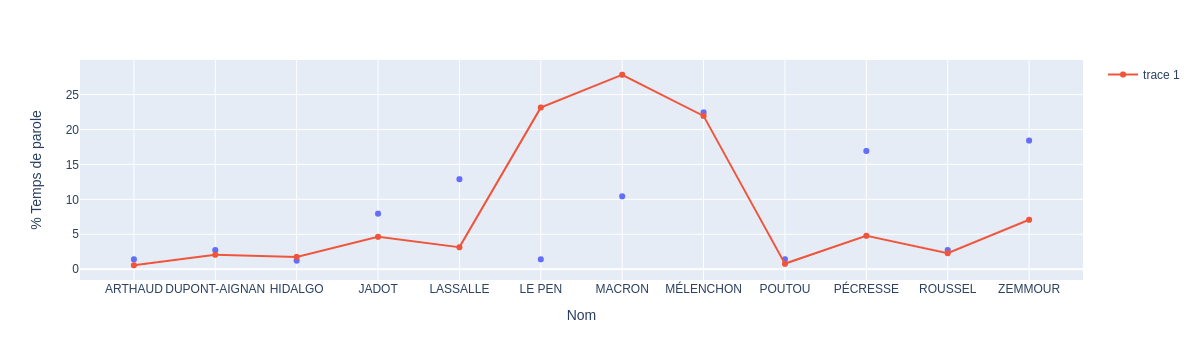

In [69]:
fig = px.scatter(candidats,
                 x='Nom', y='% Temps de parole')

fig.add_scatter(x=candidats['Nom'], y=candidats['% Votes'])
fig.show()